In [3]:
import numpy as np
import mne
import os
import sys
from mne.datasets import eegbci

## EEG Motor Movement/Imagery Dataset

1. https://www.physionet.org/content/eegmmidb/1.0.0/
2. Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE Transactions on Biomedical Engineering 51(6):1034-1043, 2004
3. https://mne.tools/stable/auto_examples/index.html

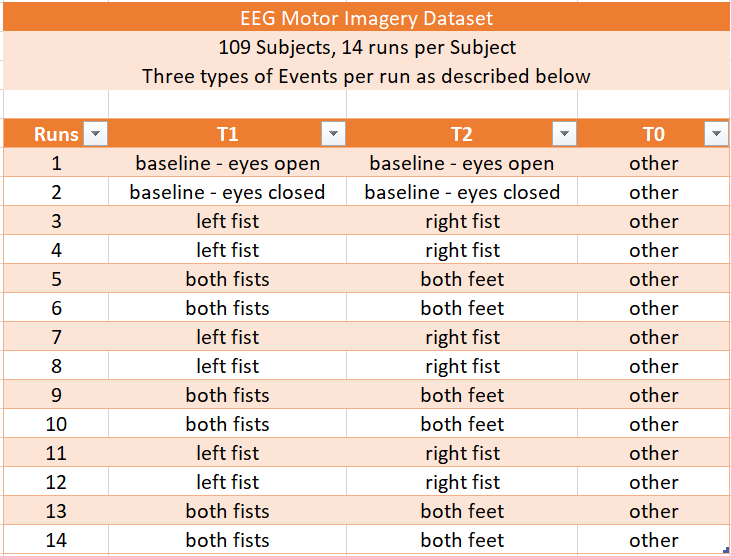

### Defining a motorImagery class for Data Loading and Pre-processing

In [63]:
class motorImagery:
    def __init__(self, path=None, subjects=[1], runs=[1]):
        self.path = path
        self.edf_filenames = self.get_filenames(path)
        self.raw = self.load_eeg(subjects, runs)
        
    def get_filenames(self, path):
        file = open(dataset_path+'RECORDS')
        edf_filenames = file.readlines()
        file.close()
        edf_filenames = [fname.rstrip() for fname in edf_filenames]
        return edf_filenames
    
    def load_eeg(self, subjects, runs):    #load -> standardize -> notch_filter -> bandpass filter -> return
    
        fno = self.get_fileIndices(subjects, runs)
        print('Loading files at index:', fno)
        
        raw_eegs = []
        for idx,i in enumerate(fno):
            path_file = os.path.join(self.path, self.edf_filenames[i])
            sys.stdout.write(f"\rLoading file #{idx+1}/{len(fno)}: {path_file}")
            raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
            raw_eegs.append(raw)

        raw = mne.io.concatenate_raws(raw_eegs)     # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        return raw                                  
    
    def get_fileIndices(self, subjects, runs):
        fno = []
        subjects = [s-1 for s in subjects]  # start from 0, 1, 2, ...
        for subject in subjects:
            for run in runs:
                fno.append(subject*14+run-1)   # 14 runs per subject
        return fno
    
    def apply_filter(self, freq):
        # Remove power line noise atrifacts at 50 Hz <-- European data so 50Hz powerline freq
        #self.raw.notch_filter(50)
        # Remove higher frequencies as they are redundant for analysis.
        low_freq, high_freq = freq
        self.raw.filter(low_freq, high_freq, fir_design='firwin')
        
    def get_ica(self, n=16):
        self.ica = mne.preprocessing.ICA(n_components=n, max_iter='auto', random_state=97)
        self.ica.fit(self.raw)
        self.raw.load_data()
        self.ica.plot_sources(self.raw)
        self.ica.plot_components()
        
    def exclude_ic(self, channels):
        self.ica.exclude = channels
        self.ica.apply(self.raw)

    def get_events(self):
        event_id = dict(T1=2, T2=3)        # Define the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        # We don't need it for now but lets include it as it is a part of the pipeline of eeg classification
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')

        # tmin and tmax are relative to the event onset time. They decide the time interval (relative to event onset) taken to 
        # form the epoch from eeg signal. 
        tmin = -1  # A second before event cue 
        tmax = 4   # Four seconds after cue. Most events are of 4.1 or 4.2 seconds long as described in annotations.

        # Read epochs (only the events described in our event_id will be included for training)
        # For future try to use baseline subtraction method 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)

        # Only eeg signals in time interval 1-2 sec will be used for training -> 1 sec after event cue to 2 sec after cue.
        # This is to avoid the evoked potentials arising in brain in response to event cue.
        epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
        montage = mne.channels.make_standard_montage('standard_1005')
        epochs_train.set_montage(montage)
        
        return epochs_train
    
    def downsample(self, epochs, factor):
        return epochs.decimate(factor)
        
    def return_epochs(self, freq=(1, 35), dsamplingFactor=2 ):
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        self.epochs = self.downsample(self.epochs, dsamplingFactor)
        self.labels = self.epochs.events[:,-1] - 2        # Convert from 2,3 to 0,1 and assign to labels for training
        return self.epochs, self.labels
    
    def get_X_y(self):
        try:
            return self.epochs.get_data(), self.labels
        except:
            self.return_epochs()
            return self.epochs.get_data(), self.labels

#### Loading data using the motorImagery class

In [64]:
dataset_path = os.path.join("H:\\","BCI Project","eeg-motor-movementimagery-dataset-1.0.0","files\\")
subjects = [1,2]
runs = [6,10,14]
eeg = motorImagery(dataset_path, subjects, runs)


Loading files at index: [5, 9, 13, 19, 23, 27]
Loading file #6/6: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S002/S002R14.edf

#### Apply Bandpass Filter 

We apply bandpass filter from 1Hz to 35Hz. This filters out slow drift potentials in the low frequency range and the higher frequencies not needed for our analysis. Powerline artifacts at 50Hz are also filtered out.

In [65]:
eeg.apply_filter(freq=(1,35))

#### Artifact Handling using ICA (Independant Component Analysis)

We define 16 components for the ICA which should be enough to separate the artifact distributions. The artifact amplitudes are usually much larger than the EEG components, thus the components of artifacts will be present in the first couple of channels of ICA. We need to exclude these from our EEG signals.

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 6.2s.
Creating RawArray with float64 data, n_channels=16, n_times=119040
    Range : 0 ... 119039 =      0.000 ...   743.994 secs
Ready.


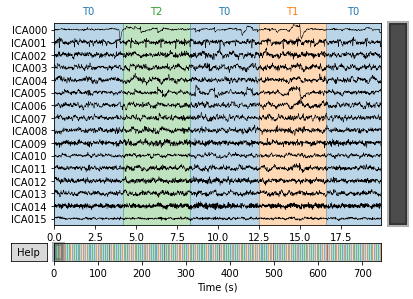

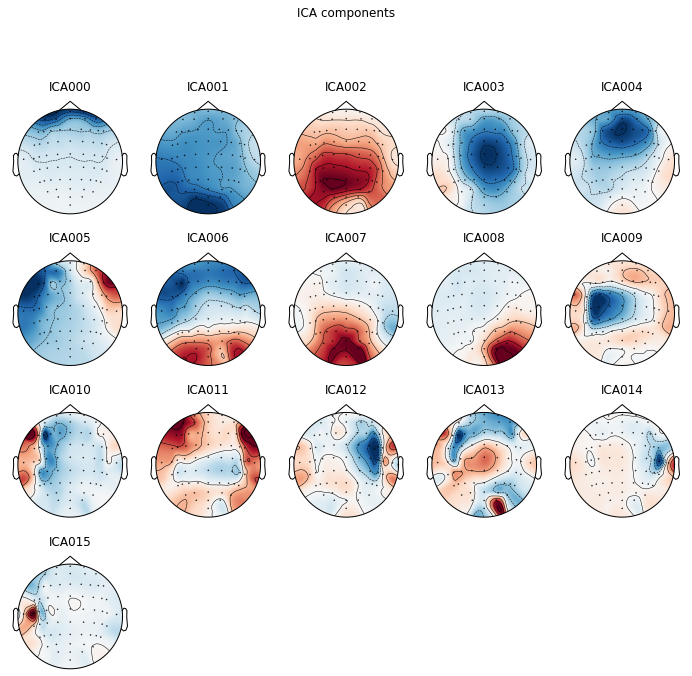

In [50]:
eeg.get_ica(16)

In [52]:
eeg.exclude_ic([0, 1])

Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


#### Plot Power Spectrum Density of Epoched EEG

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Loading data for 90 events and 801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\DELL\AppData\Local\Temp/ipykernel_1048/2142565159.py:86: RuntimeWarning: The measurement information indicates a low-pass frequency of 35 Hz. The decim=2 parameter will result in a sampling frequency of 80 Hz, which can cause aliasing artifacts.
  return epochs.decimate(factor)


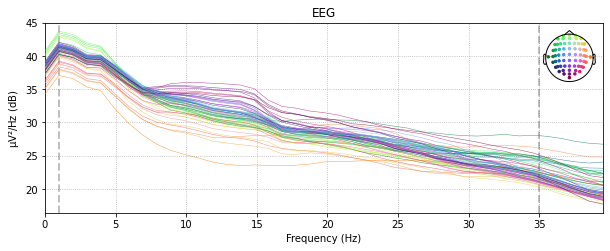

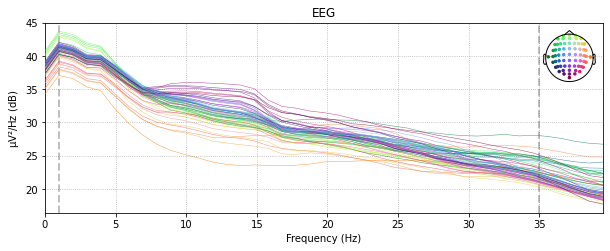

In [66]:
eeg.return_epochs()[0].plot_psd()

#### Extract Training data, X and y

In [67]:
X, y = eeg.get_X_y()

In [68]:
X.shape

(90, 64, 81)

#### Display the Two-Dimensional Training sample as an image

[1 0 0 1 0]


Text(0.5, 1.0, 'Class 0: Hands')

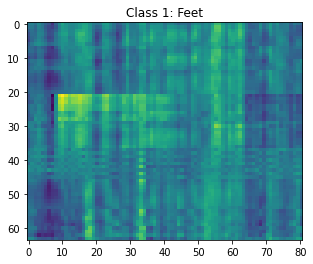

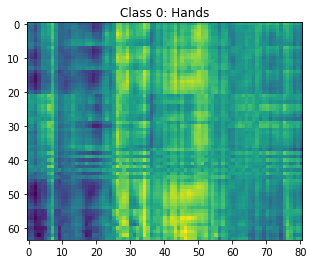

In [69]:
import matplotlib.pyplot as plt

print(y[:5])
plt.imshow(X[0])
plt.title("Class 1: Feet")
plt.figure()
plt.imshow(X[2])
plt.title("Class 0: Hands")

#### Split into Training and test samples

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Spatial Filtering using Common Spatial Patterns Algorithm

In [71]:
csp = mne.decoding.CSP(log=True, norm_trace=True)
X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 64 dim * 9.9e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


In [59]:
X_train_csp.shape

(126, 4)

#### Logistic Regression using Raw signal values

In [72]:
X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_train.shape

(63, 5184)

In [73]:
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])
X_test.shape

(27, 5184)

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.48      1.00      0.65        13

    accuracy                           0.48        27
   macro avg       0.24      0.50      0.33        27
weighted avg       0.23      0.48      0.31        27



C:\pythonBCI\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\pythonBCI\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\pythonBCI\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Logistic Regression using CSP filtered values

In [75]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_csp, y_train)
y_hat = model.predict(X_test_csp)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.45      0.36      0.40        14
           1       0.44      0.54      0.48        13

    accuracy                           0.44        27
   macro avg       0.45      0.45      0.44        27
weighted avg       0.45      0.44      0.44        27



### Further Tasks

Given X and y, perform Binary Classification to correctly identify an event as T1 or T2. 

<p>T1 = Clenching Fists  (Real or imagining)</p>
T2 = Moving Feet      (Real or imagining)

**Possible methods which may be used:**
1. Logistic Regression (Linearly separable data only) (does not seem to work well, possibly due to inclusion of irrelevant data) (May be compensated by advanced channel selection, filtering and feature engineering techniques)
2. State Vector Machines (RBF kernel ?)
3. Linear Discriminant Analysis
4. CNNs (High chance)
5. RNNs (Try)

**We may also try Feature Engineering and Selection to improve accuracy of our model.**
1. Artifact Handling using ICA (may be better to let the deep learning model handle it)
2. Common Spatial Patterns Algorithm to extract features
3. Using a subset of functionally-relevant Electrodes (channels)
4. Applying Baseline to the training data to get less noisy signal
5. Short-time Fast Fourier Transform
6. Wavelet Transform